## Clustering localities in Bangalore, India based on Restaurants (K-means Clustering)

<b>Introduction:</b>
<p>    
People visiting new cities would be highly interested in the localities with the best restaurants in the city. People might want to know how good a given restaurant is based on the ratings the restaurant has received and would like to know the price range the Restaurant falls under so that they can make informed budget decisions. Also, they would like to know the best localities where they could find these restaurants. The information of ratings and price range of various restaurants in the city and their localities in form of graphs, charts and maps would help people decide which restaurant to choose among the many restaurants in the city. And also which locality to visit. Also combining the location of the restaurants in the city with their price and rating information would help visitors make easy decisions about the locations they should visit. A map of the restaurants and another map of the localities with specific color attributes will be plotted to highlight their position. Further, we will classify the various locations into different clusters using a Machine Learning Algorithm, the K-means clustering Algorithm. This enables any visitor to take a quick glance and decide what place to visit.
    </p>
    
   <b> Data Collection:</b>
   <p>
To get location and other information about various venues in Bangalore, two APIs were used. The Foursquare API and the Zomato API.
The Foursquare’s explore API was used to fetch venues up to a range of 35 kilometers from the center of Bangalore. The names, categories and locations (latitude and longitude) of these venues were collected.
Using the name, latitude and longitude values obtained from the Foursquare API, we used the Zomato search API to fetch data from its database. The Zomato API allows to find only restaurants based on a search criteria using the name, latitude, longitude, etc.
The data from the two APIs do not match completely because Foursquare API retrieves all venues in Bangalore and the Zomato API retrieves only restaurants in Bangalore. So, we combine the two datasets to get only Restaurants from the Foursquare API and the corresponding ratings and price information from the Zomato API. We use various techniques of Data cleaning to get the final dataset.
    <br><br>
From Foursquare API, the following for each venue was retrieved:<br>
    <b>Name:</b>The name of the venue.<br>
    <b>Category:</b> The category type as defined by the API. <br>
    <b>Latitude:</b> The latitude value of the venue. <br>
    <b>Longitude:</b> The longitude value of the venue.<br><br>
From Zomato API, the following for each restaurant was retrieved: <br>
    <b>Name:</b> The name of the restaurant.<br>
    <b>Locality:</b>  The locality of the restaurant.<br>
    <b>Rating:</b>The average rating of the restaurant given be users.<br>
    <b>Price range:</b> The price ranges the restaurant belongs to as defined by Zomato.<br>
    <b>Price for two: </b>The average cost for two people dining at the restaurant.<br>
    <b>Latitude: </b>The latitude value of the restaurant. <br>
    <b>Longitude:</b> The longitude value of the restaurant.</p>

## importing necessary library

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium


## setting up four square api credentials

In [382]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20200704' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


## Banglore coordinate from google

In [3]:
Banglore_latitude=12.9716
Banglore_longitude=77.5946


## url to foursquare database to fetch detail of venues within 35 km.

In [4]:

LIMIT=10000
radius=35000
url="https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
CLIENT_ID,CLIENT_SECRET,VERSION,Banglore_latitude,Banglore_longitude,radius,LIMIT
)

## generate url

In [5]:
print(url)

https://api.foursquare.com/v2/venues/explore?&client_id=IJTG4XLADGONOJDRTQQ5TENSN0UAVOWNQAOVFJOKOMLQMUMJ&client_secret=FPZSM0LLHYZ0VMCQZ4WJHHP22KQAPUS2G23MHKZAJEHIMPQZ&v=20200704&ll=12.9716,77.5946&radius=35000&limit=10000


## a request is being sent to four square database

In [6]:
results=requests.get(url).json()

In [7]:
banglore_venues_35km=results

In [8]:
def get_banglore_venue_detail(data):
    """
    response receive from four square database is cleaned in get_banglore_venue_detail function.
    we have extracted name 'Name','Latitude','Longitude','Category'.
    """
    column=['Name','Latitude','Longitude','Category']
    venue_detail=pd.DataFrame(columns=column)
    items_data=data['response']['groups'][0]['items']
    row_set=[]
    for i in range(len(items_data)):
        row={}
        row['Name']=items_data[i]['venue']['name']
        row['Latitude']=items_data[i]['venue']['location']['lat']
        row['Longitude']=items_data[i]['venue']['location']['lng']
        row['Category']=items_data[i]['venue']['categories'][0]['name']
        row_set.append(row)
    venue_detail=pd.DataFrame(columns=column,data=row_set)
    return venue_detail
    
    

In [9]:
banglore_venues=get_banglore_venue_detail(banglore_venues_35km) # fetch all venues of banglore city

In [375]:
print("{0} venues found in banglore by fourquare database api:".format(len(banglore_venues)))

100 venues found in banglore by fourquare database api:


### Calling zomato api to get detail of resturant

In [10]:
locationUrlFromLatLong = "https://developers.zomato.com/api/v2.1/geocode?lat=12.971708980695311&lon=77.59590528412356"
header = {"User-agent": "curl/7.43.0", "Accept": "application/json", "user_key": "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"}

response = requests.get(locationUrlFromLatLong, headers=header).json()

We have store latitude and longitude of all venues return from Four square database of banglore.
With these co ordinates we will call zomato api to fetch resturant detail

In [11]:
banglore_venue_latitude=banglore_venues['Latitude'].to_list()
banglore_venue_longitude=banglore_venues['Longitude'].to_list()

We have created a function get_banglore_resturant_detail which will return pandas data frame.
Dataframe contain detail of resturant return by zomato api

Columns are 'venue_name', 'venue_latitude', 'venue_longitude', 'locality', 'average_price_for_two', 'price_range', 'aggregate_rating', 'votes',
       

In [12]:

def get_banglore_resturant_detail(data):
    resturant_detail=data['nearby_restaurants']
    row_set=[]
    for i in range(len(resturant_detail)):
        row={}
        row['venue_name']=resturant_detail[i]['restaurant']['name']
        row['venue_latitude']=resturant_detail[i]['restaurant']['location']['latitude']
        row['venue_longitude']=resturant_detail[i]['restaurant']['location']['longitude']
        row['locality']=resturant_detail[i]['restaurant']['location']['locality']
        row['average_price_for_two']=resturant_detail[i]['restaurant']['average_cost_for_two']
        row['price_range']=resturant_detail[i]['restaurant']['price_range']
        row['aggregate_rating']=resturant_detail[i]['restaurant']['user_rating']['aggregate_rating']
        row['votes']=resturant_detail[i]['restaurant']['user_rating']['votes']
        row_set.append(row)
    return pd.DataFrame(row_set)

        

100 venues found in banglore by FourSquare database:
Now we have 100 latitude and longitude of venues.
We need to call zomato api for each venues to get detail about resturant.

We have used for loop which will dynamically change the latitude and longitude of venues in url and return resturant detail
using above created function get_banglore_resturant_detail

In [13]:
banglore_resturant_details=None
for i in range(len(banglore_venue_latitude)):
    locationUrlFromLatLong="https://developers.zomato.com/api/v2.1/geocode?lat={0}&lon={1}".format(banglore_venue_latitude[i],banglore_venue_longitude[i])
    header = {"User-agent": "curl/7.43.0", "Accept": "application/json", "user_key": "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"}
    response=None
    #print(locationUrlFromLatLong)
    response = requests.get(locationUrlFromLatLong, headers=header).json()
    current_resturant_detail=get_banglore_resturant_detail(response)
    if banglore_resturant_details is None:
        banglore_resturant_details=current_resturant_detail
    else:
        banglore_resturant_details=banglore_resturant_details.append(current_resturant_detail)


We have found 900 resturant detail but we need to remove duplicate entries from resturant

In [14]:
banglore_resturant_details.describe(include="all")

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes
count,900,900,900,900,900.000000,900.000000,900,900.000000
unique,225,246,246,58,NaN,NaN,22,NaN
top,Al-Bek,13.0071348870,77.5807214901,Sadashiv Nagar,NaN,NaN,4.3,NaN
freq,38,25,25,107,NaN,NaN,160,NaN
mean,NaN,NaN,NaN,NaN,1055.500000,2.397778,NaN,7753.501111
std,NaN,NaN,NaN,NaN,594.866129,0.885927,NaN,11819.606785
min,NaN,NaN,NaN,NaN,100.000000,1.000000,NaN,3.000000
25%,NaN,NaN,NaN,NaN,600.000000,2.000000,NaN,1528.250000
50%,NaN,NaN,NaN,NaN,1000.000000,3.000000,NaN,3092.000000
75%,NaN,NaN,NaN,NaN,1500.000000,3.000000,NaN,7730.750000


## removing duplicate resuturant/venues

In [37]:
columns=banglore_resturant_details.columns

In [39]:
banglore_resturant_details.drop_duplicates(subset=columns,inplace=True)

## finally we have unique 249 venues/ resturant

In [40]:
banglore_resturant_details.describe(include="all")

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes
count,249,249,249,249,249.000000,249.000000,249,249.000000
unique,225,246,246,58,NaN,NaN,22,NaN
top,Empire Restaurant,12.8857125000,77.5449625000,Rajajinagar,NaN,NaN,4.1,NaN
freq,7,3,3,13,NaN,NaN,41,NaN
mean,NaN,NaN,NaN,NaN,940.562249,2.232932,NaN,7661.690763
std,NaN,NaN,NaN,NaN,574.018522,0.885570,NaN,13005.322473
min,NaN,NaN,NaN,NaN,100.000000,1.000000,NaN,3.000000
25%,NaN,NaN,NaN,NaN,500.000000,2.000000,NaN,1307.000000
50%,NaN,NaN,NaN,NaN,800.000000,2.000000,NaN,3092.000000
75%,NaN,NaN,NaN,NaN,1300.000000,3.000000,NaN,7038.000000


In [46]:
banglore_resturant_details.head(10)

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes
0,Green Theory,12.9686450000,77.6027430000,Residency Road,950,2,4.1,3327
1,Communiti,12.9722191879,77.6083690301,Residency Road,1500,3,4.7,7155
2,Hard Rock Cafe,12.9760339362,77.6015672833,St. Marks Road,2500,4,4.8,5920
3,Cafe Azzure,12.9749590430,77.6076025888,MG Road,900,2,4.3,3839
4,Olive Bar And Kitchen,12.9668857608,77.6081712171,Richmond Road,1800,3,4.6,2448
5,Arbor Brewing Company,12.9700615227,77.6108131930,Brigade Road,2000,4,4.2,8947
6,Church Street Social,12.9715490000,77.5985070000,Lavelle Road,1500,3,4.3,8266
7,Farzi Cafe,12.9720600755,77.5959014520,UB City,1600,3,4.5,2817
8,MISU,12.9707476387,77.6007877663,St. Marks Road,1700,3,4.4,2225
5,Brik Oven,12.9746779000,77.6054253000,Church Street,1200,3,4.4,3044


In [69]:
no_of_venues_in_area=banglore_resturant_details['locality'].value_counts()

In [85]:
no_of_venues_in_area=pd.DataFrame(data={'locality':no_of_venues_in_area.index.to_list(),'count': [ no_of_venues_in_area[i]  for i in range(len(no_of_venues_in_area))]})

Text(0, 0.5, 'count')

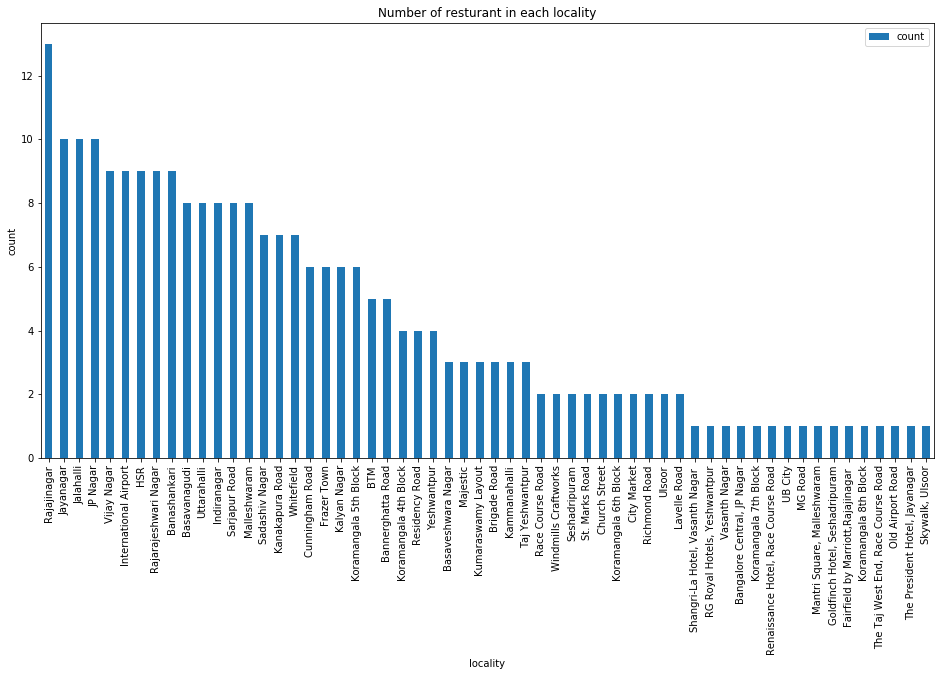

In [110]:
ax=no_of_venues_in_area.plot(kind="bar",x="locality",y="count",figsize=(16,8))
ax.set_title("Number of resturant in each locality")
ax.set_ylabel("count")


In [113]:
average_price_resturant_of_locality=banglore_resturant_details[['locality','average_price_for_two']]

In [116]:
average_price_resturant_of_locality=average_price_resturant_of_locality.groupby(['locality'],as_index=False).mean()

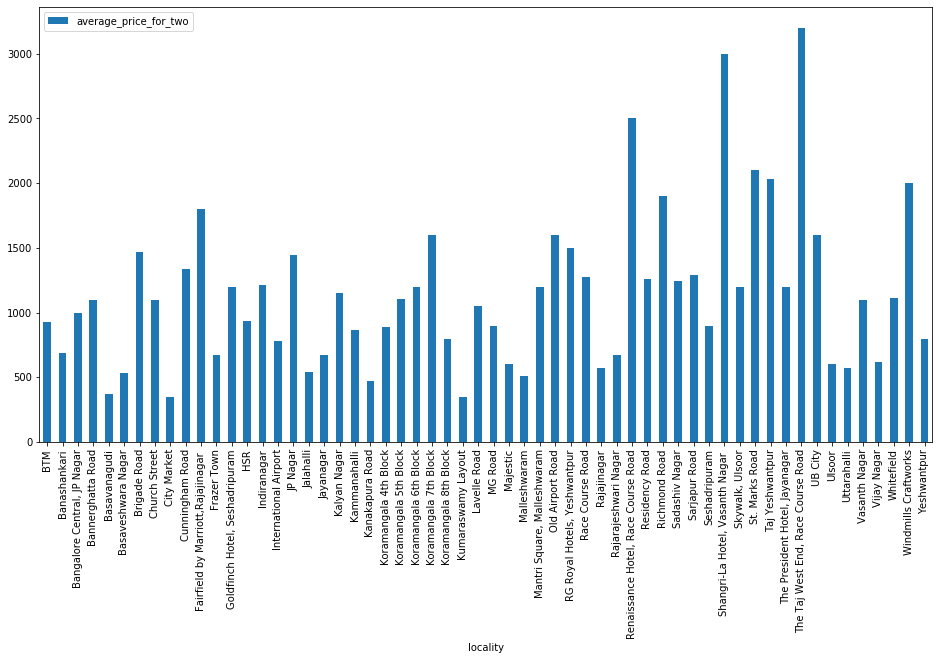

In [119]:
average_price_resturant_of_locality.plot(kind="bar",x="locality",y="average_price_for_two",figsize=(16,8))

In [129]:
banglore_resturant_details['aggregate_rating']=banglore_resturant_details[['aggregate_rating']].astype("float")

In [130]:
banglore_resturant_details.dtypes

venue_name                object
venue_latitude            object
venue_longitude           object
locality                  object
average_price_for_two      int64
price_range                int64
aggregate_rating         float64
votes                      int64
dtype: object

In [131]:
average_price__price_range__vote=banglore_resturant_details.groupby(['locality'],as_index=False).mean()

In [135]:
average_price__price_range__vote.dtypes

locality                  object
average_price_for_two    float64
price_range              float64
aggregate_rating         float64
votes                    float64
dtype: object

Text(0.5, 0, 'rating')

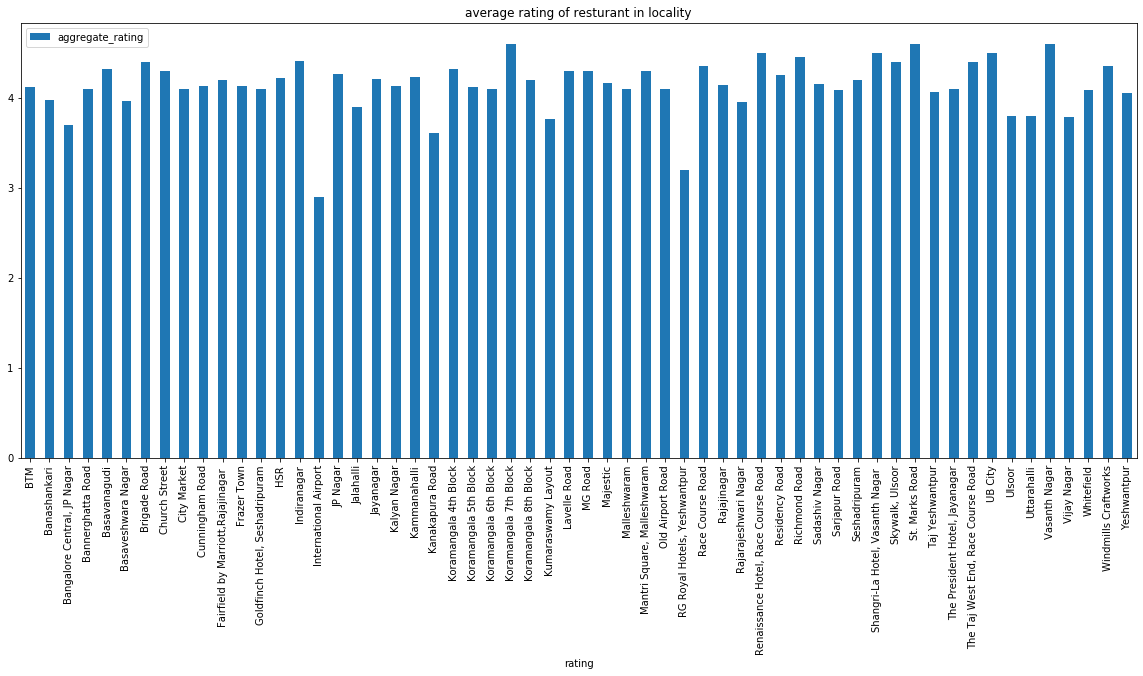

In [365]:
ax=average_price__price_range__vote.plot(kind="bar",x="locality",y="aggregate_rating",figsize=(20,8))
ax.set_title("average rating of resturant in locality")
ax.set_xlabel("rating")

In [269]:
banglore_resturant_details

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes,label
0,Green Theory,12.9686450000,77.6027430000,Residency Road,950,2,4.1,3327,3
1,Communiti,12.9722191879,77.6083690301,Residency Road,1500,3,4.7,7155,1
2,Hard Rock Cafe,12.9760339362,77.6015672833,St. Marks Road,2500,4,4.8,5920,1
3,Cafe Azzure,12.9749590430,77.6076025888,MG Road,900,2,4.3,3839,3
4,Olive Bar And Kitchen,12.9668857608,77.6081712171,Richmond Road,1800,3,4.6,2448,1
...,...,...,...,...,...,...,...,...,...
244,The Fiery Indian Kitchen,13.1901982616,77.6450468972,International Airport,700,2,3.4,4,3
245,Burgundy- Regenta Inn by Royal Orchid Hotels,13.1916747040,77.6457710937,International Airport,1700,3,0.0,3,4
246,Shivaji Restaurant,13.1914615458,77.6458411664,International Airport,300,1,3.0,5,3
247,Geetha Gardenia,13.1846230855,77.6634213701,International Airport,400,1,2.4,4,3


In [268]:
banglore_resturant_details.reset_index(drop=True,inplace=True)

In [270]:
from sklearn.preprocessing import StandardScaler

In [271]:
scaler=StandardScaler()

We will price _range and aggregate rating for clustering

In [294]:
X=banglore_resturant_details[["price_range","aggregate_rating"]]

In [295]:
X_scaled=scaler.fit_transform(X)

In [296]:
from sklearn.cluster import KMeans

We have create a for loop which will result in train 9 KMeans clustering algorithm we will select which have optimum solution

In [297]:
no_of_cluster=1

observation_result=[]
for i in range(1,10):
    result={}
    no_of_cluster=i
    resturant_cluster=KMeans(n_clusters=no_of_cluster,random_state=0)
    resturant_cluster.fit(X_scaled)
    result['no_of_cluster'],result['inertia'],result['score'],result['label']=i,resturant_cluster.inertia_,resturant_cluster.score(X_scaled),resturant_cluster.labels_
    observation_result.append(result)

In [298]:
result=pd.DataFrame(observation_result)

Text(0.5, 1.0, 'inertia vs no_of_cluster')

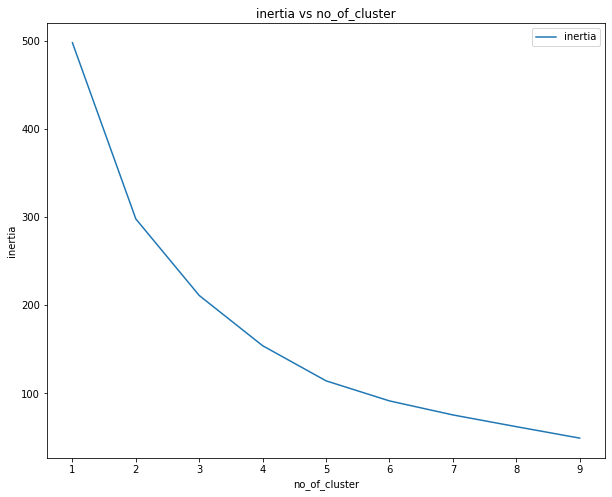

In [299]:
ax=result.plot(kind="line",x="no_of_cluster",y="inertia",figsize=(10,8))
ax.set_ylabel("inertia")
ax.set_title("inertia vs no_of_cluster")

From above graph we can see that inertia decreased a fast for first 3 cluster and later on it started decreasing a bit slow so we have choosen 3 cluster for our model

In [337]:
result={}
no_of_cluster=3
resturant_cluster=KMeans(n_clusters=no_of_cluster,random_state=0)
resturant_cluster.fit(X_scaled)
result['no_of_cluster'],result['inertia'],result['score'],result['label']=no_of_cluster,resturant_cluster.inertia_,resturant_cluster.score(X_scaled),resturant_cluster.labels_


In [338]:
banglore_resturant_details['label']=result['label']

In [368]:
banglore_resturant_details[banglore_resturant_details['label']==0]

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes,label,price_per_person
0,Green Theory,12.9686450000,77.6027430000,Residency Road,950,2,4.1,3327,0,475.0
3,Cafe Azzure,12.9749590430,77.6076025888,MG Road,900,2,4.3,3839,0,450.0
15,Dolci Desserts,12.9864065797,77.5949770957,Cunningham Road,750,2,4.2,1003,0,375.0
17,Mudpipe Cafe,12.9882900033,77.5938777253,Cunningham Road,750,2,4.0,997,0,375.0
21,The Green Path - Forgotten Food,12.9902975570,77.5718339905,Malleshwaram,600,2,3.9,1383,0,300.0
...,...,...,...,...,...,...,...,...,...,...
230,Aramane Donne Biryani,12.9082164093,77.5483224168,Uttarahalli,400,1,3.7,3747,0,400.0
235,Domino's Pizza,13.0367509818,77.5350940973,Jalahalli,400,1,4.3,6617,0,400.0
237,KFC,13.0243013184,77.5491428375,Yeshwantpur,450,1,3.8,2180,0,450.0
238,Fishing Boat,13.0208061280,77.5551885366,Yeshwantpur,300,1,3.8,6403,0,300.0


In [380]:
print("cluster 0 is in medium in terms of price and it has rating around 4")

cluster 0 is in medium in terms of price and it has rating around 4


In [367]:
banglore_resturant_details[banglore_resturant_details['label']==1]

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes,label,price_per_person
1,Communiti,12.9722191879,77.6083690301,Residency Road,1500,3,4.7,7155,1,500.000000
2,Hard Rock Cafe,12.9760339362,77.6015672833,St. Marks Road,2500,4,4.8,5920,1,625.000000
4,Olive Bar And Kitchen,12.9668857608,77.6081712171,Richmond Road,1800,3,4.6,2448,1,600.000000
5,Arbor Brewing Company,12.9700615227,77.6108131930,Brigade Road,2000,4,4.2,8947,1,500.000000
6,Church Street Social,12.9715490000,77.5985070000,Lavelle Road,1500,3,4.3,8266,1,500.000000
...,...,...,...,...,...,...,...,...,...,...
232,Azure - Taj Yeshwantpur,13.0284298260,77.5411317497,Taj Yeshwantpur,2500,4,4.0,172,1,625.000000
233,Palette - Taj Yeshwantpur,13.0282099935,77.5411119685,Taj Yeshwantpur,1800,3,4.1,268,1,600.000000
234,Hatch,13.0239867533,77.5480555370,Yeshwantpur,1200,3,4.1,223,1,400.000000
236,Paranda - Taj Yeshwantpur,13.0282740161,77.5411334261,Taj Yeshwantpur,1800,3,4.1,192,1,600.000000


In [379]:
print("cluster 1 is expensive for two person and it has rating quite high")

cluster 1 is expensive for two person and it has rating quite high


In [369]:
banglore_resturant_details[banglore_resturant_details['label']==2]

,venue_name,venue_latitude,venue_longitude,locality,average_price_for_two,price_range,aggregate_rating,votes,label,price_per_person
94,Moto Store & Café,12.9875304283,77.6208584011,Ulsoor,500,2,3.6,1595,2,250.000000
123,Pizza Hut,12.9972681672,77.5404062122,Basaveshwara Nagar,600,2,3.4,4475,2,300.000000
133,The Biryani Cafe,12.9430920694,77.5416286290,Banashankari,600,2,3.6,4025,2,300.000000
192,Cibo Esca,12.9607278692,77.5286299735,Vijay Nagar,1000,3,3.5,889,2,333.333333
195,The Charcoal,12.9609118207,77.5284368545,Vijay Nagar,1400,3,2.9,575,2,466.666667
198,Laziz Pizza,12.9616505661,77.5264684483,Vijay Nagar,600,2,3.5,4206,2,300.000000
203,Cafe Casavista,13.0669236430,77.5021555647,Jalahalli,400,1,3.4,5198,2,400.000000
204,Hotel Elite Restaurant,13.0567441294,77.5076641515,Jalahalli,750,2,3.6,5273,2,375.000000
215,Adiga's,12.8826980000,77.5466400000,Kanakapura Road,350,1,3.0,5295,2,350.000000
216,A2B - Adyar Ananda Bhavan,12.8836065745,77.5487049669,Kanakapura Road,550,2,3.1,244,2,275.000000


In [381]:
print("cluster 2 has generally low rating and  low price ")

cluster 2 has generally low rating and  low price 


In [342]:
Banglore_latitude=12.9716
Banglore_longitude=77.5946


In [355]:
banglore=folium.Map(location=[Banglore_latitude,Banglore_longitude],zoom_start=12)

In [356]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [363]:
x = np.arange(no_of_cluster)
ys = [i + x + (i*x)**3 for i in range(no_of_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [362]:
for lat, lng,rat, venue_name, cluster in zip(banglore_resturant_details['venue_latitude'],banglore_resturant_details['venue_longitude'], banglore_resturant_details['aggregate_rating'], banglore_resturant_details['venue_name'], banglore_resturant_details['label']):
    label = '{}'.format(venue_name)
    label = folium.Popup(str(venue_name) + 'comes under Cluster ' + str(cluster)+". It has aggrigate rating"+str(rat), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(banglore)  
    
banglore